## Efficient Frontier Analysis

### Data Cleaning and Preprocessing

In [28]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_validate
import cvxpy as cp
import matplotlib.pyplot as plt
import tqdm as tqdm
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.impute import SimpleImputer
from sklearn.covariance import LedoitWolf
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.covariance import GraphicalLassoCV


from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt

# 1) Load the Parquet and drop cols that were entirely NA to begin with ----
assets = (
    pd.read_parquet("/Users/nicho/OneDrive/Documents/BUSN35137/largeml.pq")
      .dropna(axis=1, how="all")   # ← drop any column with all NAs
      .assign(
          date=lambda df: pd.to_datetime(df["yyyymm"].astype(str), format="%Y%m")
                          + MonthEnd(0)
      )
      .set_index(["permno","date"])
)
assets.drop(columns=["yyyymm"], inplace=True)

# 2) Drop extremely sparse features ---------------------------------------
na_frac = assets.isna().mean()
assets.drop(columns=na_frac[na_frac > 0.5].index, inplace=True)

# 3) Forward‑fill per stock, then fill any remaining NAs -------------------
assets = assets.sort_index().groupby(level=0).ffill().fillna(0)

# 4) Cast ret to numeric & drop rows missing the target -------------------
assets['ret'] = pd.to_numeric(assets['ret'], errors='coerce')
assets = assets.dropna(subset=['ret'])

# 5) Exclude stocks with < 3 years (36 months) of data --------------------
obs_counts = assets.reset_index().groupby('permno')['date'].nunique()
good_permnos = obs_counts[obs_counts >= 36].index
assets = assets.loc[good_permnos]

# 6) Final sanity check ---------------------------------------------------
print("Final shape after filtering:", assets.shape)
print(f"Stocks retained: {len(good_permnos)} / {len(obs_counts)}")
print("Remaining NAs per column:\n", assets.isna().sum().sort_values(ascending=False).head(10))
print("Columns:", assets.columns.tolist())


C:\Users\nicho\anaconda3\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Final shape after filtering: (77071, 146)
Stocks retained: 411 / 498
Remaining NAs per column:
 AM                  0
RealizedVol         0
NOA                 0
NetDebtFinance      0
NetEquityFinance    0
NumEarnIncrease     0
OPLeverage          0
OptionVolume1       0
OptionVolume2       0
PctAcc              0
dtype: int64
Columns: ['AM', 'AOP', 'AbnormalAccruals', 'Accruals', 'AnalystRevision', 'AnalystValue', 'AnnouncementReturn', 'AssetGrowth', 'BM', 'BMdec', 'BPEBM', 'Beta', 'BetaFP', 'BetaLiquidityPS', 'BetaTailRisk', 'BidAskSpread', 'BookLeverage', 'CF', 'CPVolSpread', 'Cash', 'CashProd', 'ChAssetTurnover', 'ChEQ', 'ChInv', 'ChInvIA', 'ChNNCOA', 'ChNWC', 'ChTax', 'CompEquIss', 'CompositeDebtIssuance', 'ConvDebt', 'CoskewACX', 'Coskewness', 'CredRatDG', 'DebtIssuance', 'DelBreadth', 'DelCOA', 'DelCOL', 'DelEqu', 'DelFINL', 'DelLTI', 'DelNetFin', 'DivInit', 'DivOmit', 'DivSeason', 'DivYieldST', 'DolVol', 'EBM', 'EP', 'EarningsForecastDisparity', 'EarningsStreak', 'EarningsSurpr

### Vol Model Fitting - All Features

Modeling volatility: 100%|██████████| 411/411 [17:06<00:00,  2.50s/it]


Top 20 stocks by OOS R²:
       best_model     cv_r2
permno                     
92322          RF   0.30338
85269          RF  0.289959
47896          RF  0.268453
70519          RF  0.239328
71563          RF  0.226299
12490          RF  0.220077
90880         XGB  0.209329
12308          RF  0.202123
88215          RF  0.195049
13628          RF  0.178476
30681          RF  0.169842
89393          RF  0.164825
25778          RF  0.160565
85238          RF  0.160097
58246          RF  0.157413
10401          RF  0.157286
29647          RF   0.15388
64186          RF  0.151804
16309          RF  0.150904
12542         XGB   0.14589

Bottom 20 stocks by OOS R²:
       best_model     cv_r2
permno                     
91874         XGB -1.122107
16865        HGBR -1.155917
86979         XGB -1.262009
77274        HGBR  -1.28928
16968          RF -1.341961
13407          RF -1.475538
84788        HGBR -1.582088
86755          RF -1.592477
17519         XGB -1.596504
17787          RF -1.6

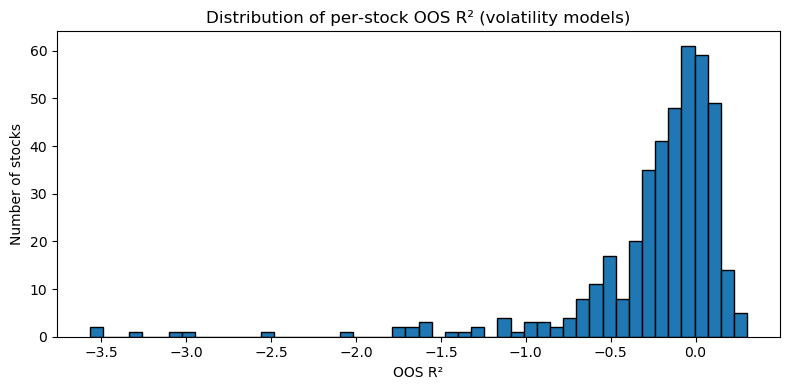

In [30]:
# 2) Prep feature & target lists -----------------------------------------
permnos = assets.index.get_level_values('permno').unique()
feature_cols = [c for c in assets.columns if c != 'ret']
tscv = TimeSeriesSplit(n_splits=5)

# 3) Define pipelines -----------------------------------------------------
pipelines = {
    'RF': Pipeline([('m', RandomForestRegressor(n_estimators=100, max_depth=8,
                                                n_jobs=-1, random_state=42))]),
    'HGBR': Pipeline([('m', HistGradientBoostingRegressor(max_iter=200,
                                                          max_depth=8,
                                                          random_state=42))]),
    'XGB': Pipeline([('m', XGBRegressor(n_estimators=100, max_depth=6,
                                        n_jobs=1, random_state=42, verbosity=0))])
    
}

# 4) Fit per‐stock volatility models --------------------------------------
cv_summary = {}
for permno in tqdm.tqdm(permnos, desc="Modeling volatility"):
    df_i = assets.xs(permno, level='permno')
    X_i = df_i[feature_cols].ffill().fillna(0)
    y_i = df_i['ret'].abs()

    best_score, best_name = -np.inf, None
    for name, pipe in pipelines.items():
        cv = cross_validate(
            pipe, X_i, y_i,
            cv=tscv,
            scoring='r2',
            return_train_score=False,
            n_jobs=1             # <--- force single‐process to avoid pickling
        )
        score = np.nanmean(cv['test_score'])
        if score > best_score:
            best_score, best_name = score, name

    cv_summary[permno] = {'best_model': best_name, 'cv_r2': best_score}

# 5) Summarize ------------------------------------------------------------
cv_df = (pd.DataFrame(cv_summary).T
            .rename_axis('permno')
            .sort_values('cv_r2', ascending=False))

print("Top 20 stocks by OOS R²:")
print(cv_df.head(20))
print("\nBottom 20 stocks by OOS R²:")
print(cv_df.tail(20))

plt.figure(figsize=(8,4))
plt.hist(cv_df['cv_r2'], bins=50, edgecolor='k')
plt.title("Distribution of per‑stock OOS R² (volatility models)")
plt.xlabel("OOS R²")
plt.ylabel("Number of stocks")
plt.tight_layout()
plt.show()

### PCA Analysis

   PC  explained_variance  cumulative_variance
0   1               0.060                0.060
1   2               0.041                0.101
2   3               0.035                0.136
3   4               0.031                0.167
4   5               0.028                0.195
5   6               0.026                0.221
6   7               0.022                0.242
7   8               0.019                0.261
8   9               0.018                0.278
9  10               0.016                0.295
80% variance in 71 PCs
85% variance in 80 PCs
90% variance in 91 PCs
95% variance in 105 PCs


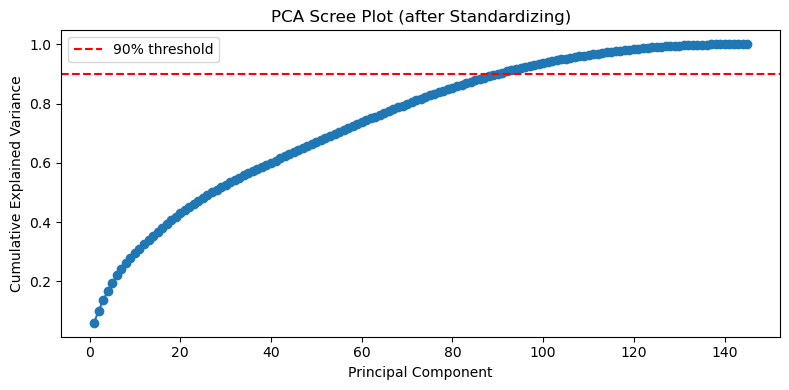

In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1) Build feature matrix (exclude target 'ret')
feature_cols = [c for c in assets.columns if c != 'ret']
X_chars = assets[feature_cols]

# 2) Standardize each column to zero mean/unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_chars)

# 3) Run PCA on the scaled matrix
pca = PCA(random_state=42)
pca.fit(X_scaled)

# 4) Scree table for first 10 PCs
evr = pca.explained_variance_ratio_
cum_evr = np.cumsum(evr)
scree = pd.DataFrame({
    'PC': np.arange(1, len(evr)+1),
    'explained_variance': evr,
    'cumulative_variance': cum_evr
})
print(scree.head(10).round(3))

# 5) How many PCs for key thresholds?
for thresh in [0.80, 0.85, 0.90, 0.95]:
    n_pc = scree[scree['cumulative_variance'] >= thresh]['PC'].iloc[0]
    print(f"{int(thresh*100)}% variance in {n_pc} PCs")

# 6) Scree plot
plt.figure(figsize=(8,4))
plt.plot(scree['PC'], scree['cumulative_variance'], marker='o')
plt.axhline(0.90, color='red', linestyle='--', label='90% threshold')
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot (after Standardizing)")
plt.legend()
plt.tight_layout()
plt.show()


### Vol Model with PCA

Vol modeling (30 PCs): 100%|██████████| 411/411 [16:25<00:00,  2.40s/it]

Top 20 stocks by OOS R² (30 PCs):
       best_model     cv_r2
permno                     
16309          RF  0.219988
69032          RF  0.165406
12542         XGB  0.158622
92156        HGBR  0.107881
80100          RF  0.100016
64995          RF  0.078272
89195          RF  0.074387
62148          RF  0.072802
13628          RF  0.064643
30681          RF  0.064196
60442          RF  0.062239
90878          RF  0.054943
16595          RF  0.049707
64186          RF  0.043901
91143          RF  0.037189
71563          RF  0.028401
58246          RF  0.020422
88490          RF  0.019308
14714          RF  0.018684
88215          RF  0.016574

Bottom 20 stocks by OOS R² (30 PCs):
       best_model     cv_r2
permno                     
91950        HGBR  -1.86431
91321          RF -1.882736
86111        HGBR -2.030416
92257        HGBR -2.070832
91277        HGBR -2.090825
91207          RF -2.165532
86755          RF -2.303199
84788         XGB  -2.40583
13407         XGB -2.632617
1778

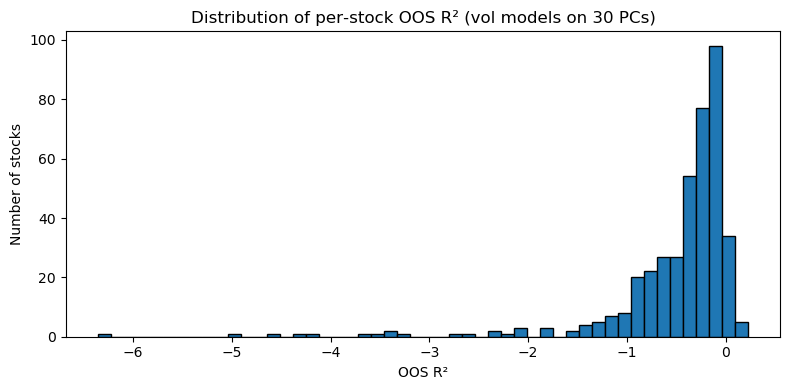

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate
import tqdm
import matplotlib.pyplot as plt

# 1) Prepare and scale the characteristic matrix
feature_cols = [c for c in assets.columns if c != 'ret']
X_chars      = assets[feature_cols]
scaler       = StandardScaler()
X_scaled     = scaler.fit_transform(X_chars)

# 2) PCA reduction to 80 components
n_pcs = 80
pca    = PCA(n_components=n_pcs, random_state=42)
pcs    = pca.fit_transform(X_scaled)
pc_cols = [f"PC{i+1}" for i in range(n_pcs)]

# 3) Build a new DataFrame with the PCs + target
assets_pca = pd.DataFrame(pcs, index=assets.index, columns=pc_cols)
assets_pca['ret'] = assets['ret'].abs()

# 4) Set up modeling
permnos = assets_pca.index.get_level_values('permno').unique()
tscv    = TimeSeriesSplit(n_splits=5)
pipelines = {
    'RF'  : RandomForestRegressor(n_estimators=100, max_depth=8,
                                  n_jobs=-1, random_state=42),
    'HGBR': HistGradientBoostingRegressor(max_iter=200, max_depth=8,
                                          random_state=42),
    'XGB' : XGBRegressor(n_estimators=100, max_depth=6,
                         n_jobs=1, random_state=42, verbosity=0)
}

# 5) Per‑stock CV loop
cv_summary = {}
for permno in tqdm.tqdm(permnos, desc="Vol modeling (30 PCs)"):
    df_i = assets_pca.xs(permno, level='permno')
    X_i  = df_i[pc_cols]
    y_i  = df_i['ret']
    if len(y_i) < tscv.get_n_splits() + 1:
        continue

    best_score, best_model = -np.inf, None
    for name, model in pipelines.items():
        cv      = cross_validate(model, X_i, y_i,
                                 cv=tscv, scoring='r2',
                                 return_train_score=False, n_jobs=1,
                                 error_score=np.nan)
        score   = np.nanmean(cv['test_score'])
        if score > best_score:
            best_score, best_model = score, name

    cv_summary[permno] = {'best_model': best_model, 'cv_r2': best_score}

# 6) Summarize
cv_df = (pd.DataFrame(cv_summary).T
            .rename_axis('permno')
            .sort_values('cv_r2', ascending=False))

print("Top 20 stocks by OOS R² (30 PCs):")
print(cv_df.head(20))
print("\nBottom 20 stocks by OOS R² (30 PCs):")
print(cv_df.tail(20))

plt.figure(figsize=(8,4))
plt.hist(cv_df['cv_r2'], bins=50, edgecolor='k')
plt.title("Distribution of per‑stock OOS R² (vol models on 30 PCs)")
plt.xlabel("OOS R²")
plt.ylabel("Number of stocks")
plt.tight_layout()
plt.show()


### Supervised Feature Selection

In [36]:
import pandas as pd
import numpy as np

# 1) Grab the volatility target and feature matrix
y = assets['ret'].abs()
X = assets.drop(columns=['ret'])

# 2) Compute |ρ| for each feature against y over the pooled panel
cors = X.apply(lambda col: np.abs(col.corr(y)))

# 3) Sort descending
cors = cors.sort_values(ascending=False)

# 4) Inspect the distribution
print(cors.describe().round(4))
print("\nTop 10 features by |ρ|:\n", cors.head(10))
print("\nBottom 10 features by |ρ|:\n", cors.tail(10))


count    145.0000
mean       0.0599
std        0.0985
min        0.0001
25%        0.0117
50%        0.0315
75%        0.0686
max        0.5793
dtype: float64

Top 10 features by |ρ|:
 RealizedVol     0.579337
IdioVol3F       0.578087
MaxRet          0.568283
IdioVolAHT      0.444186
BidAskSpread    0.399403
RIVolSpread     0.314317
Beta            0.219158
High52          0.209118
Cash            0.148031
fgr5yrLag       0.136102
dtype: float64

Bottom 10 features by |ρ|:
 BPEBM               0.002373
HerfAsset           0.001632
HerfBE              0.001500
GrSaleToGrInv       0.001413
ChInvIA             0.001278
PriceDelaySlope     0.000949
ShareIss1Y          0.000830
EarningsSurprise    0.000687
ChAssetTurnover     0.000675
ShareIss5Y          0.000122
dtype: float64


In [37]:
# 1) Compute the median |ρ| threshold
threshold = cors.median()   # ≈0.0315

# 2) Select features above that threshold
kept_feats = cors[cors >= threshold].index.tolist()
print(f"Keeping {len(kept_feats)} features (|ρ| ≥ {threshold:.4f})")

# 3) Build a pruned assets DataFrame
assets_pruned = assets[kept_feats + ['ret']].copy()

# 4) Quick sanity
print("Pruned shape:", assets_pruned.shape)
print("Pruned features:", kept_feats)


Keeping 73 features (|ρ| ≥ 0.0315)
Pruned shape: (77071, 74)
Pruned features: ['RealizedVol', 'IdioVol3F', 'MaxRet', 'IdioVolAHT', 'BidAskSpread', 'RIVolSpread', 'Beta', 'High52', 'Cash', 'fgr5yrLag', 'MomOffSeason', 'ShortInterest', 'IndIPO', 'VolumeTrend', 'ReturnSkew', 'BetaFP', 'XFIN', 'CPVolSpread', 'hire', 'DelEqu', 'LRreversal', 'TrendFactor', 'EarningsStreak', 'AM', 'CompEquIss', 'Leverage', 'Coskewness', 'ReturnSkew3F', 'AnnouncementReturn', 'IntanEP', 'GP', 'NetEquityFinance', 'FirmAge', 'VolMkt', 'DelCOL', 'IntanCFP', 'ForecastDispersion', 'IntanSP', 'DelCOA', 'AssetGrowth', 'OptionVolume2', 'OPLeverage', 'InvestPPEInv', 'VarCF', 'PriceDelayTstat', 'AnalystRevision', 'CredRatDG', 'BM', 'Spinoff', 'BetaTailRisk', 'skew1', 'AbnormalAccruals', 'SmileSlope', 'MomSeason', 'OptionVolume1', 'ChInv', 'VolSD', 'MomOffSeason06YrPlus', 'CF', 'NOA', 'NetDebtFinance', 'MRreversal', 'Mom12mOffSeason', 'ExclExp', 'DelFINL', 'IndMom', 'dNoa', 'Investment', 'Illiquidity', 'dVolCall', 'ConvDe

### Feature Selection Decision

In [39]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate

# 0) Compute the univariate |ρ| series
y_abs = assets['ret'].abs()
feature_cols = [c for c in assets.columns if c != 'ret']
cors = assets[feature_cols].apply(lambda col: abs(col.corr(y_abs))).sort_values(ascending=False)

# 1) Set up
quantiles = [0.25, 0.50, 0.75]
tscv      = TimeSeriesSplit(n_splits=5)
permnos   = assets.index.get_level_values('permno').unique()

pipelines = {
    'RF'  : RandomForestRegressor(n_estimators=100, max_depth=8, n_jobs=-1, random_state=42),
    'HGBR': HistGradientBoostingRegressor(max_iter=200, max_depth=8, random_state=42),
    'XGB' : XGBRegressor(n_estimators=100, max_depth=6, n_jobs=1, random_state=42, verbosity=0),
}

summary = []

# 2) Sweep quantiles
for q in quantiles:
    thresh     = cors.quantile(q)
    kept_feats = cors[cors >= thresh].index.tolist()
    
    r2s = []
    for permno in tqdm.tqdm(permnos, desc=f"Quantile {q:.2f}"):
        df_i = assets.xs(permno, level='permno')
        X_i  = df_i[kept_feats].ffill().fillna(0)
        y_i  = df_i['ret'].abs()
        if len(y_i) < tscv.get_n_splits() + 1:
            continue
        
        best = -np.inf
        for model in pipelines.values():
            cv = cross_validate(
                model, X_i, y_i,
                cv=tscv,
                scoring='r2',
                n_jobs=1,
                error_score=np.nan
            )
            best = max(best, np.nanmean(cv['test_score']))
        r2s.append(best)
    
    r2s = np.array(r2s)
    summary.append({
        'quantile'     : q,
        'n_features'   : len(kept_feats),
        'median_r2'    : np.nanmedian(r2s),
        'mean_r2'      : np.nanmean(r2s),
        'pct_positive' : np.mean(r2s > 0)
    })

# 3) Report results
df_summary = pd.DataFrame(summary).set_index('quantile')
print(df_summary.round(3))


Quantile 0.75: 100%|██████████| 411/411 [12:00<00:00,  1.75s/it]

          n_features  median_r2  mean_r2  pct_positive
quantile                                              
0.25             109     -0.096   -0.219         0.331
0.50              73     -0.075   -0.178         0.343
0.75              37     -0.095   -0.182         0.321


### Vol Modeling with Condensed Data

Keeping 73 features with |ρ| ≥ 0.0315


Fitting per‑stock vol models: 100%|██████████| 411/411 [15:53<00:00,  2.32s/it]

Top 20 stocks by OOS R² (pruned features):
       best_model     cv_r2
permno                     
92322          RF  0.334945
47896          RF  0.273993
85269          RF  0.273001
25778          RF  0.244713
71563          RF  0.233679
16309          RF  0.231746
12490          RF  0.227986
85238          RF  0.225141
12542         XGB  0.220328
13628          RF   0.21763
89393          RF  0.217048
85261         XGB  0.192637
34746          RF  0.190775
70519          RF  0.190487
12308          RF  0.188835
81055          RF  0.184754
29647          RF  0.164241
70500          RF  0.163606
15408          RF  0.163489
86158          RF  0.163475

Bottom 20 stocks by OOS R² (pruned features):
       best_model     cv_r2
permno                     
86755         XGB -0.810771
91874          RF -0.842617
81540          RF  -0.86314
82775          RF -0.872137
16917        HGBR -0.880999
15735          RF -0.929189
12872          RF -0.961127
17787          RF -1.039908
14040        H

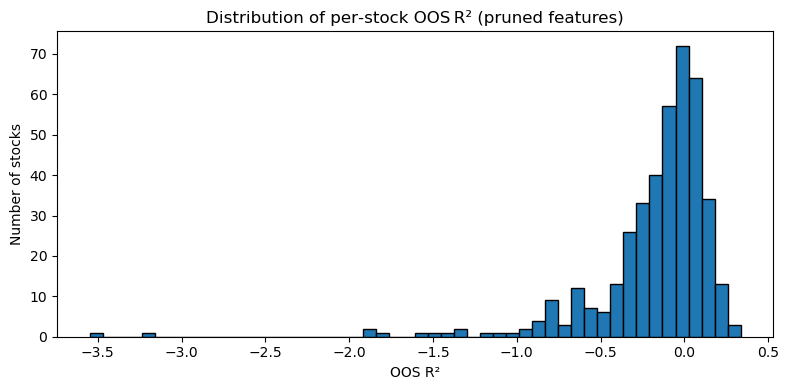

In [41]:
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate

# — assume you already have:
#    • assets (cleaned, filtered to ≥36 months)
#    • cors (Series of |ρ| per feature vs |ret|)

# 1) Prune to top‐50% by |ρ|
threshold    = cors.median()
kept_feats   = cors[cors >= threshold].index.tolist()
print(f"Keeping {len(kept_feats)} features with |ρ| ≥ {threshold:.4f}")

# 2) Build pruned panel
assets_pruned = assets[kept_feats + ['ret']]

# 3) Prep
permnos      = assets_pruned.index.get_level_values('permno').unique()
feature_cols = kept_feats
tscv         = TimeSeriesSplit(n_splits=5)

# 4) Pipelines
pipelines = {
    'RF'  : RandomForestRegressor(n_estimators=100, max_depth=8,
                                  n_jobs=-1, random_state=42),
    'HGBR': HistGradientBoostingRegressor(max_iter=200, max_depth=8,
                                          random_state=42),
    'XGB' : XGBRegressor(n_estimators=100, max_depth=6,
                         n_jobs=1, random_state=42, verbosity=0)
}

# 5) CV loop + σ̂ forecast
cv_summary = {}
sigma_hat  = {}
for permno in tqdm.tqdm(permnos, desc="Fitting per‑stock vol models"):
    df_i = assets_pruned.xs(permno, level='permno')
    X_i  = df_i[feature_cols].ffill().fillna(0)
    y_i  = df_i['ret'].abs()
    if len(y_i) < tscv.get_n_splits() + 1:
        continue

    # pick best model by OOS R²
    best_score, best_name = -np.inf, None
    for name, model in pipelines.items():
        cv = cross_validate(model, X_i, y_i,
                            cv=tscv, scoring='r2',
                            n_jobs=1, error_score=np.nan)
        score = np.nanmean(cv['test_score'])
        if score > best_score:
            best_score, best_name = score, name

    cv_summary[permno] = {'best_model': best_name, 'cv_r2': best_score}

    # fit on full history & forecast next‑month vol
    m = pipelines[best_name]
    m.fit(X_i, y_i)
    sigma_hat[permno] = m.predict(X_i.iloc[[-1]])[0]

# 6) Summarize CV results
cv_df = (pd.DataFrame(cv_summary).T
           .rename_axis('permno')
           .sort_values('cv_r2', ascending=False))

print("Top 20 stocks by OOS R² (pruned features):")
print(cv_df.head(20))
print("\nBottom 20 stocks by OOS R² (pruned features):")
print(cv_df.tail(20))

plt.figure(figsize=(8,4))
plt.hist(cv_df['cv_r2'].dropna(), bins=50, edgecolor='k')
plt.title("Distribution of per‑stock OOS R² (pruned features)")
plt.xlabel("OOS R²")
plt.ylabel("Number of stocks")
plt.tight_layout()
plt.show()

# 7) Turn sigma_hat into a Series for easy lookup
sigma_hat = pd.Series(sigma_hat, name='sigma_hat')


### Efficient Frontier Curve ML Vol vs Historical Vol

C:\Users\nicho\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:241: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


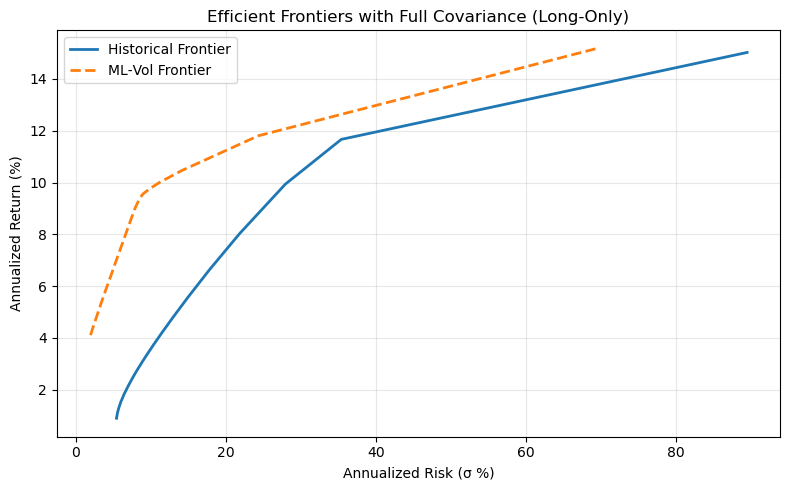

In [43]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf

# ----------------------------------------------------------------------
# 1) Prepare return matrix and ML‐vol forecasts (all in decimal form)
# ----------------------------------------------------------------------
# assets_pruned['ret'] is monthly decimal returns (e.g. 0.014 = 1.4%)
# sigma_hat is a pd.Series of monthly decimal σ̂ per permno
R = assets_pruned['ret'].unstack('permno')
common     = sigma_hat.index.intersection(R.columns)
R_imp      = R[common].fillna(0.0)          # impute missing → 0
permnos    = R_imp.columns.tolist()
n          = len(permnos)

# drop any tickers with zero variance
stds    = R_imp.std()
non_zero = stds[stds > 0].index.tolist()
R_clean = R_imp[non_zero]
sigma_m = sigma_hat.loc[non_zero].values   # monthly decimal σ̂

# ----------------------------------------------------------------------
# 2) Build full covariances via Ledoit–Wolf + ML‐correlation method
# ----------------------------------------------------------------------
# 2a) Historical full covariance (monthly)
lw              = LedoitWolf().fit(R_clean.values)
Sigma_hist_mth  = lw.covariance_            # shape: (n,n)
# 2b) ML vol covariance: use historical corr but σ̂ on diag
corr            = R_clean.corr().values
Sigma_ml_mth    = corr * np.outer(sigma_m, sigma_m)

# 2c) Annualize both (monthly → annual)
Sigma_hist_ann = Sigma_hist_mth * 12
Sigma_ml_ann   = Sigma_ml_mth   * 12

# ----------------------------------------------------------------------
# 3) γ‑sweep with PSD wrap to build frontiers
# ----------------------------------------------------------------------
mu_m = R_clean.mean().values             # monthly expected returns (decimal)
gammas = np.linspace(0.01, 50, 100)

# CVXPY parameters
Σp = cp.Parameter((n,n))
μp = cp.Parameter(n)

front_hist = []
front_ml   = []

for Σ_num, front in ((Sigma_hist_ann, front_hist), (Sigma_ml_ann, front_ml)):
    Σp.value = Σ_num
    μp.value = mu_m

    for γ in gammas:
        w = cp.Variable(n)
        # wrap Σ to avoid ARPACK PSD‐check failures
        Q = cp.psd_wrap(Σp)
        prob = cp.Problem(
            cp.Maximize(μp @ w - (γ/2)*cp.quad_form(w, Q)),
            [cp.sum(w) == 1, w >= 0]
        )
        try:
            prob.solve(solver=cp.OSQP, verbose=False)
        except:
            prob.solve(solver=cp.SCS,  verbose=False)

        if prob.status == cp.OPTIMAL and w.value is not None:
            r_m = float(mu_m @ w.value)
            v_m = float(np.sqrt(w.value.T @ Σ_num @ w.value))
            front.append((v_m, r_m))

# ----------------------------------------------------------------------
# 4) Annualize & convert to percentage for plotting
# ----------------------------------------------------------------------
vol_h_pct = [v*np.sqrt(12)*100 for v,_ in front_hist]
ret_h_pct = [r   *12   *100 for _,r in front_hist]
vol_ml_pct= [v*np.sqrt(12)*100 for v,_ in front_ml]
ret_ml_pct= [r   *12   *100 for _,r in front_ml]

# ----------------------------------------------------------------------
# 5) Plot
# ----------------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(vol_h_pct, ret_h_pct, label='Historical Frontier', linewidth=2)
plt.plot(vol_ml_pct,   ret_ml_pct,   '--', label='ML‑Vol Frontier', linewidth=2)
plt.xlabel('Annualized Risk (σ %)')
plt.ylabel('Annualized Return (%)')
plt.title('Efficient Frontiers with Full Covariance (Long‑Only)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### Return Modeling

In [45]:
import warnings
import numpy as np
import pandas as pd
import tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning

# -----------------------------------------------------------------------------
# 0) Suppress unwanted warnings
# -----------------------------------------------------------------------------
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message=".*does not converge.*")
warnings.filterwarnings("ignore", message=".*Objective did not converge.*")
warnings.filterwarnings("ignore", message=".*SettingWithCopyWarning.*")

# -----------------------------------------------------------------------------
# 1) Prune features by correlation (reuse 'cors' from earlier) 
# -----------------------------------------------------------------------------
threshold  = cors.median()
kept_feats = cors[cors >= threshold].index.tolist()
print(f"Keeping {len(kept_feats)} features with |ρ| ≥ {threshold:.4f}")

# -----------------------------------------------------------------------------
# 2) Build pruned panel for returns
# -----------------------------------------------------------------------------
# 'assets' is your cleaned permno×date DataFrame with all features + 'ret'
assets_ret = assets[kept_feats + ['ret']]

# -----------------------------------------------------------------------------
# 3) Prepare cross‐validation
# -----------------------------------------------------------------------------
tscv    = TimeSeriesSplit(n_splits=5)
permnos = assets_ret.index.get_level_values('permno').unique()

# -----------------------------------------------------------------------------
# 4) Define return‐forecasting pipelines
# -----------------------------------------------------------------------------
ffill   = FunctionTransformer(lambda X: pd.DataFrame(X).ffill().values, validate=False)
imp     = SimpleImputer(strategy='median')

lasso = LassoCV(alphas=np.logspace(-3,1,5),
                cv=3,
                max_iter=2000,
                tol=1e-3,
                n_jobs=1,
                random_state=42)

pipelines_ret = {
    'RF'   : Pipeline([('ffill', ffill), ('imp', imp),
                       ('m', RandomForestRegressor(
                           n_estimators=100, max_depth=8,
                           n_jobs=-1, random_state=42))]),
    'HGBR' : Pipeline([('ffill', ffill), ('imp', imp),
                       ('m', HistGradientBoostingRegressor(
                           max_iter=100, max_depth=6,
                           random_state=42))]),
    'XGB'  : Pipeline([('ffill', ffill), ('imp', imp),
                       ('m', XGBRegressor(
                           n_estimators=100, max_depth=6,
                           n_jobs=4, random_state=42,
                           verbosity=0))]),
    'Ridge': Pipeline([('ffill', ffill), ('imp', imp), ('scale', StandardScaler()),
                       ('m', RidgeCV(alphas=[0.1,1.0,10.0]))]),
    'Lasso': Pipeline([('ffill', ffill), ('imp', imp), ('scale', StandardScaler()),
                       ('m', lasso)]),
    'PCA+RF': Pipeline([('ffill', ffill), ('imp', imp), ('scale', StandardScaler()),
                        ('pca', PCA(n_components=20)),
                        ('m', RandomForestRegressor(
                            n_estimators=100, max_depth=8,
                            n_jobs=-1, random_state=42))]),
    'SKB+RF': Pipeline([('ffill', ffill), ('imp', imp),
                        ('skb', SelectKBest(f_regression, k=20)),
                        ('m', RandomForestRegressor(
                            n_estimators=100, max_depth=8,
                            n_jobs=-1, random_state=42))]),
}

# -----------------------------------------------------------------------------
# 5) Cross‐validate & fit per‐stock return models
# -----------------------------------------------------------------------------
cv_results_ret = {}
mu_hat         = {}

for perm in tqdm.tqdm(permnos, desc="Fitting per‑stock return models"):
    df_i = assets_ret.xs(perm, level='permno')
    if len(df_i) < tscv.get_n_splits() + 1:
        continue

    # target = next‑period return
    y_i = df_i['ret']
    # features = pruned set
    X_i = df_i[kept_feats]

    # select best model by OOS R²
    best_name, best_r2 = None, -np.inf
    for name, pipe in pipelines_ret.items():
        cv = cross_validate(pipe, X_i, y_i,
                            cv=tscv,
                            scoring='r2',
                            n_jobs=1,
                            error_score=np.nan)
        r2 = np.nanmean(cv['test_score'])
        if r2 > best_r2:
            best_r2, best_name = r2, name

    cv_results_ret[perm] = {'best_model': best_name, 'cv_r2': best_r2}

    # fit best pipeline on full history + forecast next‑month μ̂
    model = pipelines_ret[best_name]
    model.fit(X_i, y_i)
    mu_hat[perm] = model.predict(X_i.iloc[[-1]])[0]

# -----------------------------------------------------------------------------
# 6) Summarize cross‐validation
# -----------------------------------------------------------------------------
cv_df_ret = (pd.DataFrame(cv_results_ret).T
                .rename_axis('permno')
                .sort_values('cv_r2', ascending=False))

print("\nTop 20 stocks by OOS R² (returns):")
print(cv_df_ret.head(20))
print("\nBottom 20 stocks by OOS R² (returns):")
print(cv_df_ret.tail(20))

# 7) Convert mu_hat into a Series
mu_hat = pd.Series(mu_hat, name='mu_hat')


Keeping 73 features with |ρ| ≥ 0.0315


Fitting per‑stock return models:  13%|█▎        | 53/411 [03:10<20:05,  3.37s/it]C:\Users\nicho\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:381: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
Fitting per‑stock return models:  27%|██▋       | 113/411 [06:09<15:35,  3.14s/it]C:\Users\nicho\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:381: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
Fitting per‑stock return models:  52%|█████▏    | 215/411 [13:36<14:00,  4.29s/it]C:\Users\nicho\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:381: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
C:\Users\nicho\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_se


Top 20 stocks by OOS R² (returns):
       best_model     cv_r2
permno                     
86868      SKB+RF  0.563982
16309      SKB+RF  0.543076
93096       Lasso  0.505277
11955       Lasso  0.493101
92611      SKB+RF  0.491435
89003          RF  0.458054
93089       Lasso  0.457137
93002       Lasso  0.457033
15478       Lasso  0.454063
90796       Lasso  0.446246
12994       Lasso  0.440964
90319          RF  0.436961
90520          RF  0.430662
13447       Lasso  0.430057
79323       Lasso  0.425953
75034       Lasso  0.419715
86021      SKB+RF  0.417879
87432      SKB+RF  0.414466
89393      SKB+RF  0.412769
92614       Lasso  0.411187

Bottom 20 stocks by OOS R² (returns):
       best_model     cv_r2
permno                     
86111          RF -0.234357
17787        HGBR -0.267646
14040          RF -0.269792
89130        HGBR -0.285177
17746        HGBR -0.316537
83440      PCA+RF -0.323381
11003      SKB+RF -0.404087
17972      SKB+RF -0.473152
16932      SKB+RF -0.512309
1

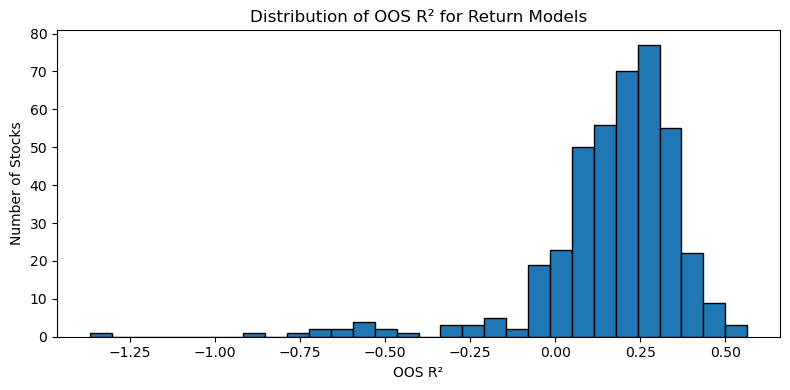

In [46]:
import matplotlib.pyplot as plt

# assume cv_df_ret is your DataFrame of OOS R² per permno
r2 = cv_df_ret['cv_r2'].dropna()

plt.figure(figsize=(8,4))
plt.hist(r2, bins=30, edgecolor='k')
plt.title('Distribution of OOS R² for Return Models')
plt.xlabel('OOS R²')
plt.ylabel('Number of Stocks')
plt.tight_layout()
plt.show()

### Efficient Frontier Curve with ML Mu and Vol

C:\Users\nicho\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:241: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


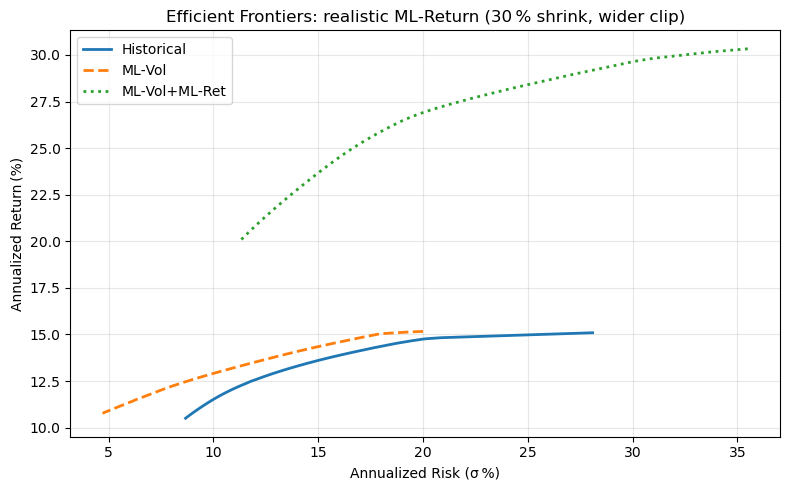

In [48]:
import numpy as np, cvxpy as cp, matplotlib.pyplot as plt

# monthly inputs -----------------------------------------------------------
permnos  = R_clean.columns.tolist(); n = len(permnos)
mu_hist  = R_clean.mean().values              # monthly hist μ
raw_ml   = mu_hat.loc[permnos].values         # monthly ML μ̂
Σ_hist   = Sigma_hist_mth                     # monthly Σ
Σ_ml     = Sigma_ml_mth

# shrink (15 %) + wider clip  ----------------------------------------------
mu_ml = 0.15 * raw_ml
low, high = mu_hist.min(), mu_hist.max()*2     # allow up to ~0.08 monthly
mu_ml = np.clip(mu_ml, low, high)

# γ‑sweep -------------------------------------------------------------------
Σp, μp = cp.Parameter((n,n), PSD=True), cp.Parameter(n)
gammas = np.linspace(0.1, 10, 50); sqrt12 = np.sqrt(12)
solvers = [cp.OSQP, cp.ECOS, cp.SCS]

def solve(Sig, mu, g):
    Σp.value, μp.value = Sig, mu
    w = cp.Variable(n)
    P = cp.Problem(cp.Maximize(μp@w - (g/2)*cp.quad_form(w, cp.psd_wrap(Σp))),
                   [cp.sum(w)==1, w>=0])
    for s in solvers:
        try:
            P.solve(solver=s, verbose=False)
            if P.status == cp.OPTIMAL and w.value is not None:
                return w.value
        except: pass
    return None

def frontier(Sig, mu):
    pts=[]
    for g in gammas:
        w = solve(Sig, mu, g)
        if w is None: continue
        vol = np.sqrt(w.T@Sig@w); ret = mu@w
        pts.append((vol*sqrt12*100, ret*12*100))
    return zip(*pts) if pts else ([],[])

vh,rh = frontier(Σ_hist, mu_hist)
vm,rm = frontier(Σ_ml,   mu_hist)
va,ra = frontier(Σ_ml,   mu_ml)

# plot ----------------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(vh,rh,label='Historical',lw=2)
plt.plot(vm,rm,'--',label='ML‑Vol',lw=2)
plt.plot(va,ra,':',label='ML‑Vol+ML‑Ret',lw=2)
plt.xlabel('Annualized Risk (σ %)'); plt.ylabel('Annualized Return (%)')
plt.title('Efficient Frontiers: realistic ML‑Return (30 % shrink, wider clip)')
plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()


### Backtesting and Performance

In [ ]:
import warnings
warnings.filterwarnings("ignore", message=".*n_splits.*")
warnings.filterwarnings("ignore", message=".*DPP.*")

import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV, LassoCV

# — assume in scope —
# • assets_pruned      : MultiIndex DataFrame (permno,date) with kept_feats + ['ret']
# • pipelines          : dict name→vol‐model estimator
# • cv_summary         : dict permno→{'best_model','cv_r2'} from vol CV
# • pipelines_ret      : dict name→return‐model Pipeline (will modify below)
# • cv_results_ret     : dict permno→{'best_model','cv_r2'} from return CV
# • kept_feats         : list of feature column names

# 0) redefine only the Ridge and Lasso pipelines to use cv=2
ffill = FunctionTransformer(lambda X: pd.DataFrame(X).ffill().values, validate=False)
imp   = SimpleImputer(strategy='median')

pipelines_ret['Ridge'] = Pipeline([
    ('ffill', ffill), ('imp', imp), ('scale', StandardScaler()),
    ('m', RidgeCV(alphas=[0.1,1.0,10.0], cv=2))
])
pipelines_ret['Lasso'] = Pipeline([
    ('ffill', ffill), ('imp', imp), ('scale', StandardScaler()),
    ('m', LassoCV(alphas=np.logspace(-3,1,5), cv=2,
                  max_iter=2000, tol=1e-3, random_state=42))
])

# 1) Lookups for each ticker’s best vol & ret model
best_vol  = {p:info['best_model'] for p,info in cv_summary.items()}
best_ret  = {p:info['best_model'] for p,info in cv_results_ret.items()}
vol_pipes = pipelines
ret_pipes = pipelines_ret

# 2) prepare wide return matrix for realized‐P&L
R = assets_pruned['ret'].unstack('permno')

# 3) build (t0, t1) rebalance pairs
all_dates = R.index.unique().sort_values()
pairs     = [(all_dates[i], all_dates[i+1]) for i in range(60, len(all_dates)-1)]

# 4) backtest over dynamic universe
port_rets = []
for t0, t1 in pairs:
    # tickers live at t0
    live = assets_pruned.xs(t0, level='date').index.tolist()
    mus, sigs = [], []
    for perm in live:
        df_i = assets_pruned.xs(perm, level='permno')
        hist = df_i[df_i.index <= t0]
        X    = hist[kept_feats].ffill().fillna(0)

        # vol forecast with fallback
        try:
            vm   = vol_pipes[ best_vol[perm] ]
            yvol = hist['ret'].abs()
            vm.fit(X, yvol)
            sigs.append(vm.predict(X.iloc[[-1]])[0])
        except:
            sigs.append(yvol.mean())

        # return forecast with fallback
        try:
            rm   = ret_pipes[ best_ret[perm] ]
            yret = hist['ret']
            rm.fit(X, yret)
            mus.append(rm.predict(X.iloc[[-1]])[0])
        except:
            mus.append(yret.mean())

    if not live:
        port_rets.append(0.0)
        continue

    mu_vec  = np.array(mus)
    sig_vec = np.array(sigs)
    Sigma   = np.diag(sig_vec**2)

    # solve MV
    n      = len(live)
    w      = cp.Variable(n)
    Σp     = cp.Parameter((n,n), PSD=True)
    μp     = cp.Parameter(n)
    Σp.value, μp.value = Sigma, mu_vec

    prob = cp.Problem(
        cp.Maximize(μp @ w - 0.5*cp.quad_form(w, Σp)),
        [cp.sum(w) == 1, w >= 0]
    )
    try:
        prob.solve(solver=cp.OSQP, verbose=False)
    except:
        prob.solve(solver=cp.SCS, verbose=False)

    w_opt = w.value if w.value is not None else np.zeros(n)

    # realized return at t1 (missing → 0)
    realized = R.reindex(index=[t1], columns=live).iloc[0].fillna(0).values
    port_rets.append(w_opt.dot(realized))

# 5) performance & plot
reb_dates = [t0 for t0,_ in pairs]
rets      = pd.Series(port_rets, index=reb_dates)
cumret    = (1 + rets).cumprod()
sharpe    = rets.mean() / rets.std() * np.sqrt(12)

print(f"Cumulative return: {cumret.iloc[-1]:.2f}×")
print(f"Annualized Sharpe:  {sharpe:.2f}")

plt.figure(figsize=(8,4))
cumret.plot(title="Monthly Rolling MV Backtest")
plt.ylabel("Cumulative Return")
plt.xlabel("Rebalance Date")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\nicho\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:381: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
C:\Users\nicho\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:381: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
C:\Users\nicho\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:381: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
C:\Users\nicho\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:381: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
C:\Users\nicho\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:381: Runti